## Requirements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load and clean dataset

In [2]:
dataset = pd.read_csv("data/cleaned_5250.csv")
missing_values_idx = dataset.isna().any(axis=1)
clean_dataset = dataset[~missing_values_idx]
clean_dataset.shape

(4765, 13)

Classifiication task: Predict the planet type

In [3]:
clean_dataset

,name,distance,stellar_magnitude,planet_type,discovery_year,mass_multiplier,mass_wrt,radius_multiplier,radius_wrt,orbital_radius,orbital_period,eccentricity,detection_method
0,11 Comae Berenices b,304.0,4.72307,Gas Giant,2007,19.40000,Jupiter,1.080,Jupiter,1.290000,0.892539,0.23,Radial Velocity
1,11 Ursae Minoris b,409.0,5.01300,Gas Giant,2009,14.74000,Jupiter,1.090,Jupiter,1.530000,1.400000,0.08,Radial Velocity
2,14 Andromedae b,246.0,5.23133,Gas Giant,2008,4.80000,Jupiter,1.150,Jupiter,0.830000,0.508693,0.00,Radial Velocity
3,14 Herculis b,58.0,6.61935,Gas Giant,2002,8.13881,Jupiter,1.120,Jupiter,2.773069,4.800000,0.37,Radial Velocity
4,16 Cygni B b,69.0,6.21500,Gas Giant,1996,1.78000,Jupiter,1.200,Jupiter,1.660000,2.200000,0.68,Radial Velocity
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5245,XO-7 b,764.0,10.52100,Gas Giant,2019,0.70900,Jupiter,1.373,Jupiter,0.044210,0.007940,0.04,Transit
5246,YSES 2 b,357.0,10.88500,Gas Giant,2021,6.30000,Jupiter,1.140,Jupiter,115.000000,1176.500000,0.00,Direct Imaging
5247,YZ Ceti b,12.0,12.07400,Terrestrial,2017,0.70000,Earth,0.913,Earth,0.016340,0.005476,0.06,Radial Velocity
5248,YZ Ceti c,12.0,12.07400,Super Earth,2017,1.14000,Earth,1.050,Earth,0.021560,0.008487,0.00,Radial Velocity


In [4]:
num_obeservation = 4000
df = dataset.iloc[range(num_obeservation)]
df = df.drop("name", axis=1)
df.head()

,distance,stellar_magnitude,planet_type,discovery_year,mass_multiplier,mass_wrt,radius_multiplier,radius_wrt,orbital_radius,orbital_period,eccentricity,detection_method
0,304.0,4.72307,Gas Giant,2007,19.40000,Jupiter,1.08,Jupiter,1.290000,0.892539,0.23,Radial Velocity
1,409.0,5.01300,Gas Giant,2009,14.74000,Jupiter,1.09,Jupiter,1.530000,1.400000,0.08,Radial Velocity
2,246.0,5.23133,Gas Giant,2008,4.80000,Jupiter,1.15,Jupiter,0.830000,0.508693,0.00,Radial Velocity
3,58.0,6.61935,Gas Giant,2002,8.13881,Jupiter,1.12,Jupiter,2.773069,4.800000,0.37,Radial Velocity
4,69.0,6.21500,Gas Giant,1996,1.78000,Jupiter,1.20,Jupiter,1.660000,2.200000,0.68,Radial Velocity


In [5]:
# mass transformation: The dataset contains a mass calculation based on two planets. We unify that into a single mass variable
jupiter_mass_kg = 1.898 * 10**27 #kg
jupiter_radius_km = 69911 #km
earth_mass_kg = 5.972 * 10**24
earth_radius_km = 6378
df["mass_wrt"] = np.where(df["mass_wrt"] == "Jupiter", jupiter_mass_kg, earth_mass_kg)
df["mass"] = np.multiply(df["mass_multiplier"], df["mass_wrt"])
df["radius_wrt"] = np.where(df["radius_wrt"] == "Jupiter", jupiter_radius_km, earth_radius_km)
df["radius"] = np.multiply(df["radius_multiplier"], df["radius_wrt"])
df = df.drop(["mass_wrt", "radius_wrt", "mass_multiplier", "radius_multiplier"], axis=1)
print(df, df.shape)

      distance  stellar_magnitude   planet_type  discovery_year  \
0        304.0            4.72307     Gas Giant            2007   
1        409.0            5.01300     Gas Giant            2009   
2        246.0            5.23133     Gas Giant            2008   
3         58.0            6.61935     Gas Giant            2002   
4         69.0            6.21500     Gas Giant            1996   
...        ...                ...           ...             ...   
3995     981.0           13.96500  Neptune-like            2013   
3996     981.0           13.96500   Super Earth            2013   
3997     981.0           13.96500   Super Earth            2013   
3998    2739.0           14.00100  Neptune-like            2016   
3999    2486.0           13.56300  Neptune-like            2016   

      orbital_radius  orbital_period  eccentricity detection_method  \
0           1.290000        0.892539          0.23  Radial Velocity   
1           1.530000        1.400000          0.08  R

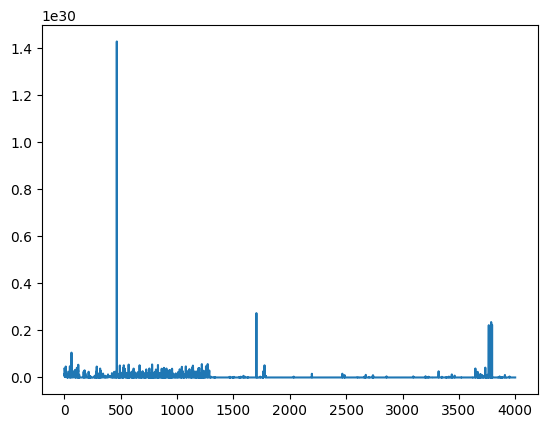

In [6]:
plt.plot(df["mass"])

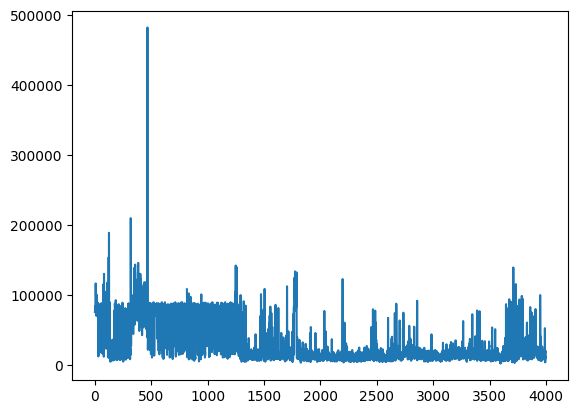

In [7]:
plt.plot(df["radius"])

## Standardization

Note for us to the future: When we do training, make sure to first separate the training and test set, and do the standardization separately, so no info "leaks" from the test set into our training set.

In [8]:

planet_type = df["planet_type"]
encoded_df = df.copy()
#we encode the categorical variables, to make it digestable for the training stage later
encoded_df["detection_method"] = encoded_df["detection_method"].astype("category").cat.codes
encoded_df["planet_type"] = encoded_df["planet_type"].astype("category").cat.codes

#we have a separate df, so that the standardization is only done for the non-categorical variables
df_without_type = encoded_df.drop(["planet_type", "detection_method"] , axis=1)

df_std = (df_without_type - np.mean(df_without_type, axis=0)) / np.std(df_without_type, axis=0)
print(np.std(df_std, axis=0))

#we add back everything
df_std["planet_type"] = encoded_df["planet_type"]
df_std["detection_method"] = encoded_df["detection_method"]
df_std

distance             1.0
stellar_magnitude    1.0
discovery_year       1.0
orbital_radius       1.0
orbital_period       1.0
eccentricity         1.0
mass                 1.0
radius               1.0
dtype: float64


,distance,stellar_magnitude,discovery_year,orbital_radius,orbital_period,eccentricity,mass,radius,planet_type,detection_method
0,-0.894718,-2.467447,-1.951415,-0.033395,-0.022228,1.074501,1.356407,1.368047,0,4
1,-0.826711,-2.375854,-1.491067,-0.031589,-0.022199,0.063556,1.003858,1.390008,0,4
2,-0.932284,-2.306881,-1.721241,-0.036856,-0.022250,-0.475615,0.251856,1.521772,0,4
3,-1.054050,-1.868386,-3.102286,-0.022236,-0.022007,2.018050,0.504451,1.455890,0,4
4,-1.046925,-1.996126,-4.483330,-0.030611,-0.022154,4.107338,0.023380,1.631576,0,4
...,...,...,...,...,...,...,...,...,...,...
3995,-0.456233,0.452208,-0.570371,-0.042198,-0.022276,-0.475615,-0.107951,-0.613029,1,5
3996,-0.456233,0.452208,-0.570371,-0.039888,-0.022259,-0.475615,-0.102714,-0.681147,2,5
3997,-0.456233,0.452208,-0.570371,-0.037699,-0.022237,-0.475615,-0.102952,-0.721217,2,5
3998,0.682403,0.463581,0.120151,-0.038790,-0.022253,-0.475615,-0.108856,-0.380024,1,5


In [9]:
planet_cats = df["planet_type"].astype("category")
print(planet_cats.cat.categories) 
detection_cats = df["detection_method"].astype("category")
print(detection_cats.cat.categories) 


Index(['Gas Giant', 'Neptune-like', 'Super Earth', 'Terrestrial'], dtype='object')
Index(['Astrometry', 'Direct Imaging', 'Disk Kinematics',
       'Eclipse Timing Variations', 'Radial Velocity', 'Transit',
       'Transit Timing Variations'],
      dtype='object')


## Classification problem

In [10]:
X_classification = df_std.drop("planet_type", axis=1)
y_classification = df_std["planet_type"]

assert X_classification.shape == (num_obeservation, 9)
assert y_classification.shape == (num_obeservation,)

## Histogram

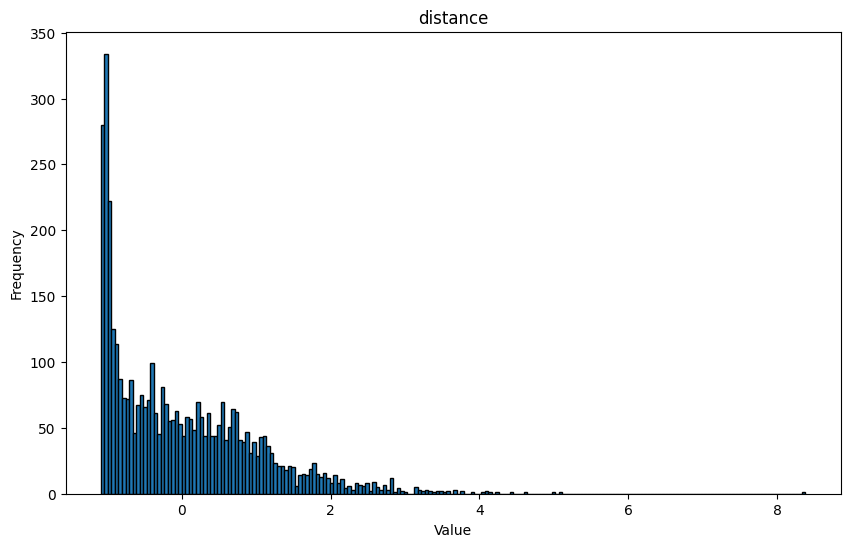

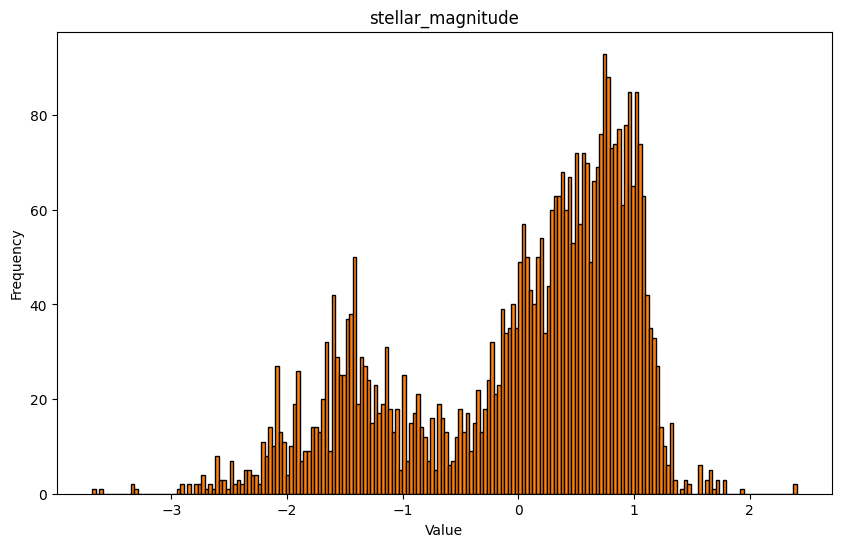

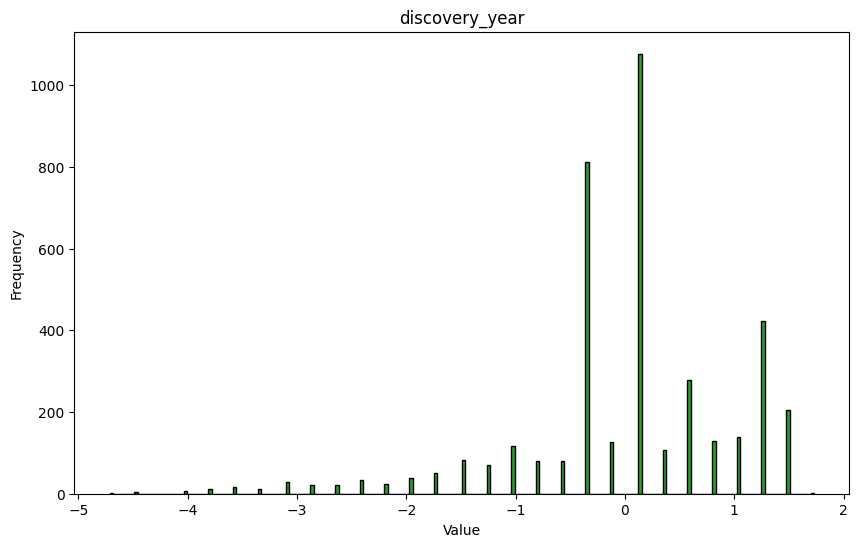

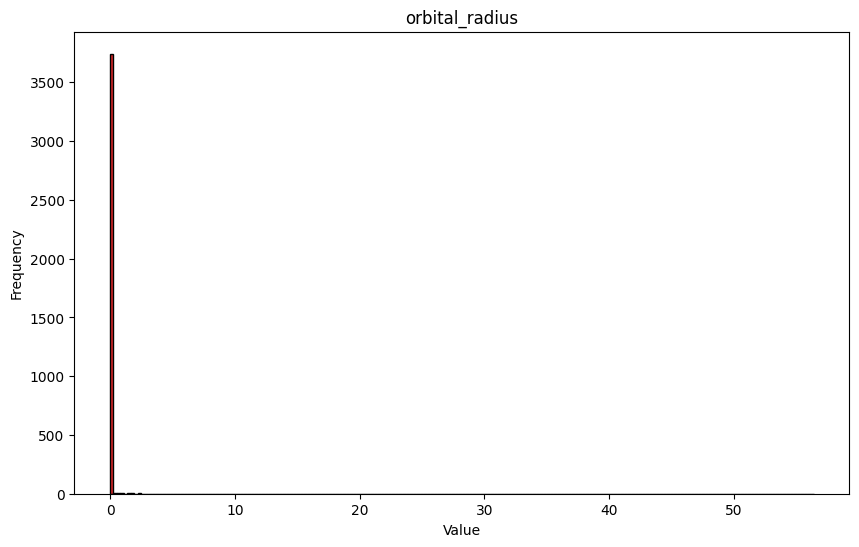

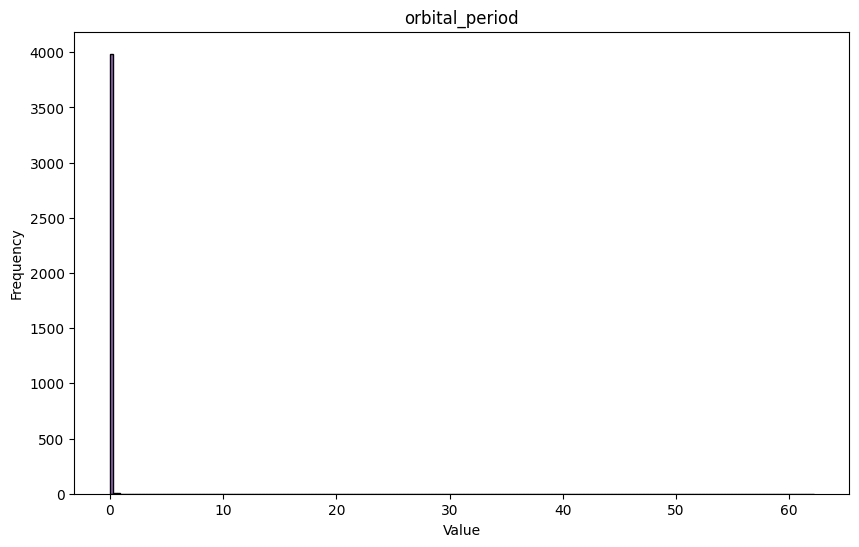

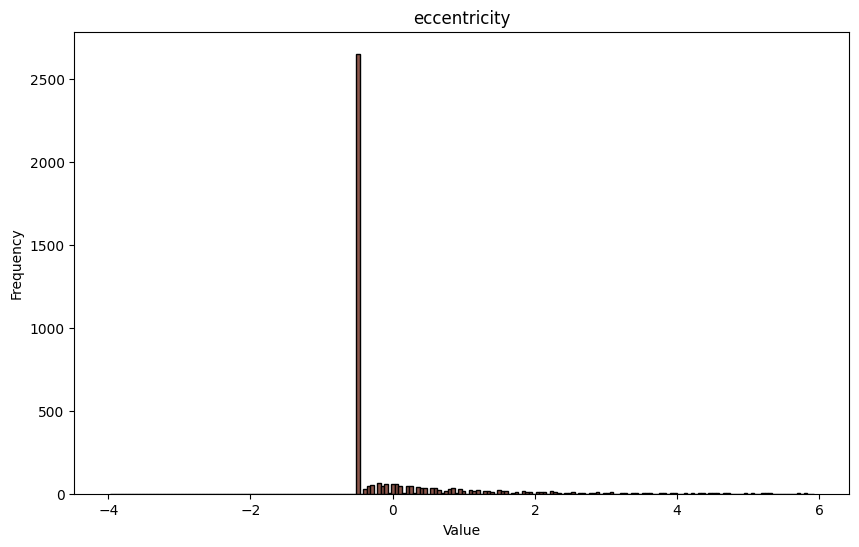

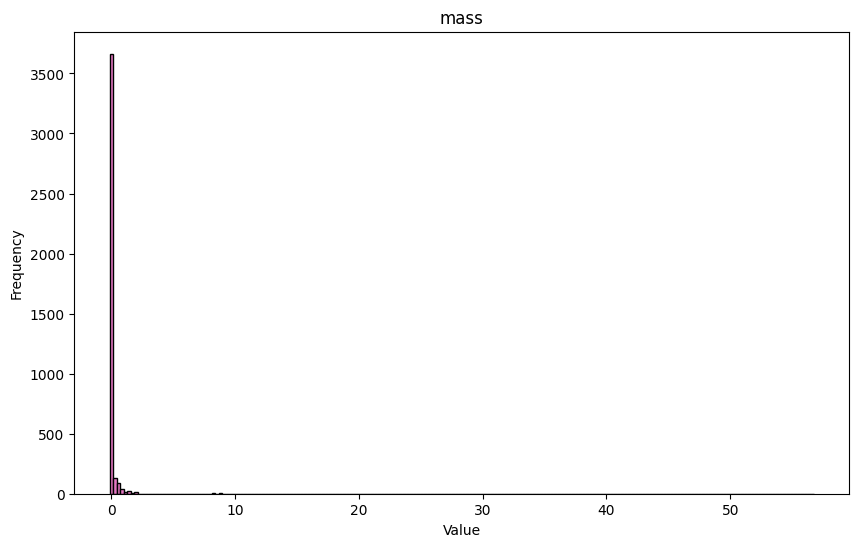

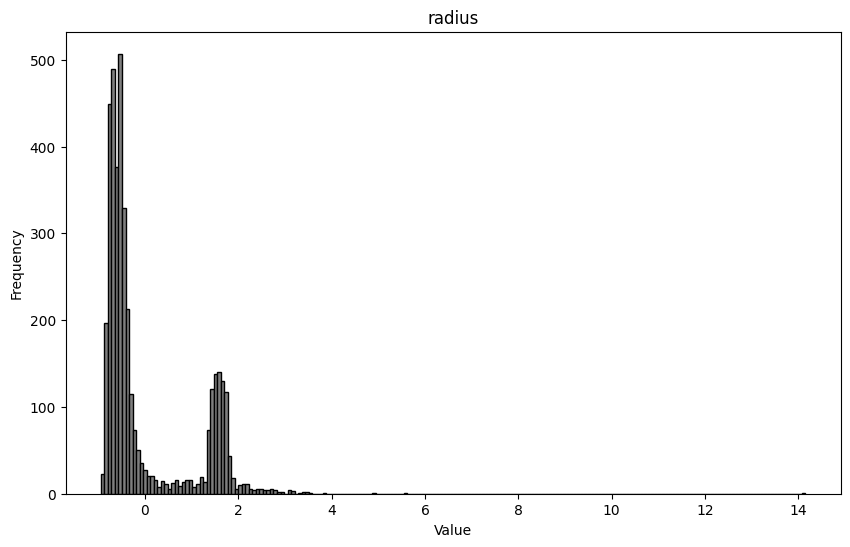

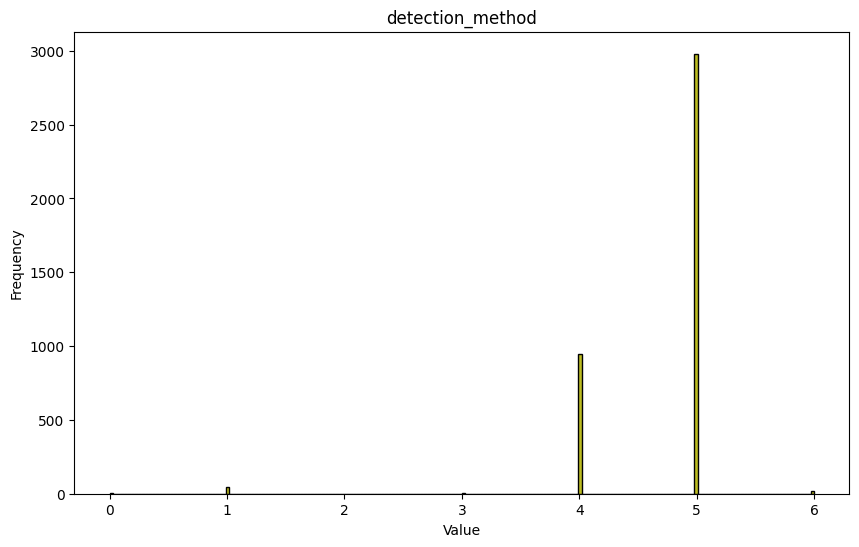

In [11]:
for i in range(9):
    plt.figure(figsize=(10,6))
    plt.hist(X_classification.iloc[:, i], color=f"C{i}", bins=200, edgecolor='black')
    plt.title(X_classification.columns[i])
    plt.xlabel("Value")
    plt.ylabel("Frequency")


## Plotting attributes

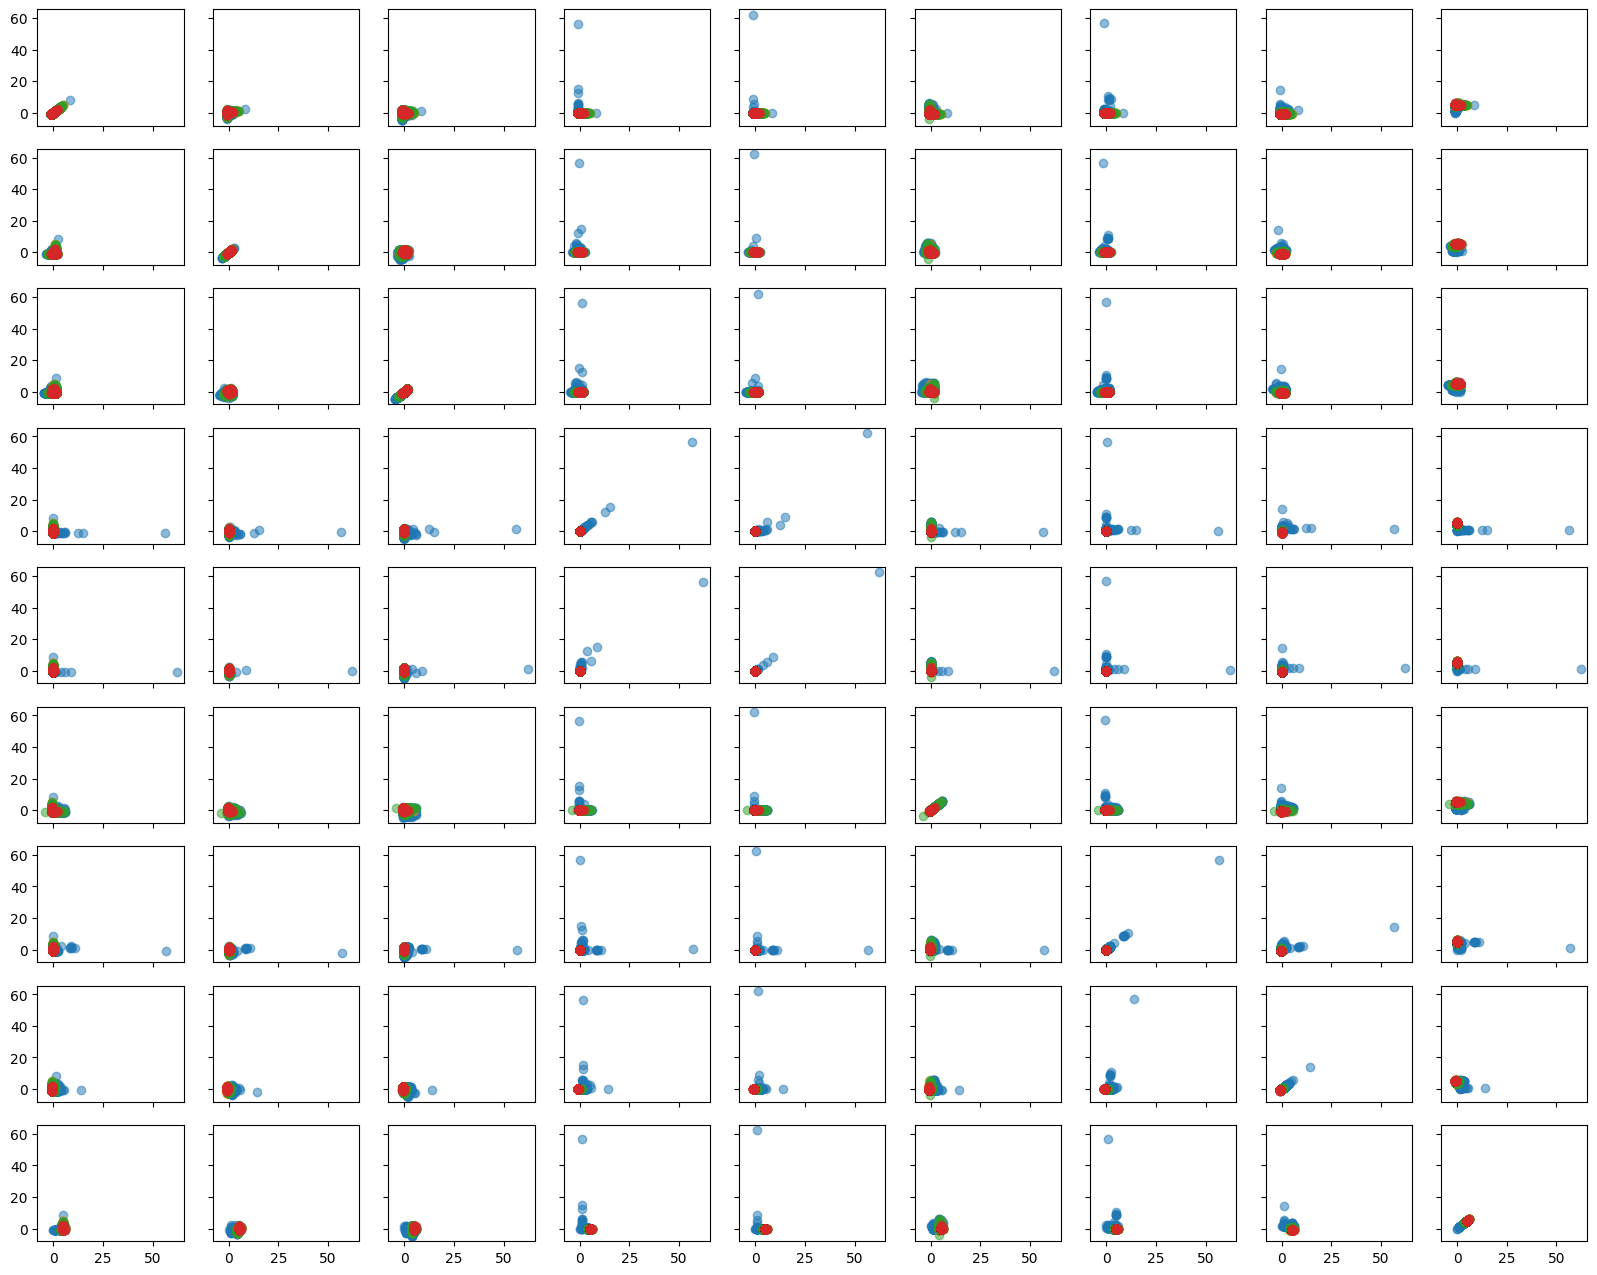

In [12]:
fig, axs = plt.subplots(9, 9, figsize=(20, 16), sharex='col', sharey='row')
for i in range(9):
    for j in range(9):
        for type in y_classification.unique():
            mask = (y_classification == type)
            axs[j, i].scatter(
                x=X_classification[mask][X_classification.columns[j]],
                y=X_classification[mask][X_classification.columns[i]],
                label=type,
                alpha=0.5
            )

plt.show()

TODO:

PCA analysis

KNN - maybe?

Describe each attribute. This is more documentation and reasoning why we chose the ones we have now

correlation pairs between attributes

Few other visualizations maybe based on what other people tried also in our references, and some own experiments


Important: For standardization. We should standardize before the PCA and the pair plots, but don't standardize for the raw data visualization in the beginning.


Covariance Analysis

In [13]:
cov_pairs = df_std.cov()
cov_pairs

,distance,stellar_magnitude,discovery_year,orbital_radius,orbital_period,eccentricity,mass,radius,planet_type,detection_method
distance,1.000251,0.635235,0.120925,-0.041645,-0.022627,-0.359753,-0.044638,-0.304749,0.187409,0.265401
stellar_magnitude,0.635235,1.000251,0.267601,-0.028690,-0.007656,-0.516235,-0.116630,-0.571388,0.419063,0.385951
discovery_year,0.120925,0.267601,1.000250,0.007828,0.015944,-0.187085,-0.033949,-0.333482,0.234167,0.149258
orbital_radius,-0.041645,-0.028690,0.007828,1.000265,0.993582,-0.008790,0.035437,0.071996,-0.047919,-0.144281
orbital_period,-0.022627,-0.007656,0.015944,0.993582,1.000250,-0.010210,0.012020,0.034576,-0.025667,-0.082603
eccentricity,-0.359753,-0.516235,-0.187085,-0.008790,-0.010210,1.000250,0.084637,0.479339,-0.380593,-0.253171
mass,-0.044638,-0.116630,-0.033949,0.035437,0.012020,0.084637,1.000251,0.355015,-0.126230,-0.130140
radius,-0.304749,-0.571388,-0.333482,0.071996,0.034576,0.479339,0.355015,1.000250,-0.707969,-0.337321
planet_type,0.187409,0.419063,0.234167,-0.047919,-0.025667,-0.380593,-0.126230,-0.707969,0.750584,0.246926
detection_method,0.265401,0.385951,0.149258,-0.144281,-0.082603,-0.253171,-0.130140,-0.337321,0.246926,0.356065


In [17]:
cor_pairs = df_without_type.corr()
cor_pairs

,distance,stellar_magnitude,discovery_year,orbital_radius,orbital_period,eccentricity,mass,radius
distance,1.000000,0.634905,0.120990,-0.040912,-0.022594,-0.359280,-0.044577,-0.304735
stellar_magnitude,0.634905,1.000000,0.267680,-0.028367,-0.007680,-0.515921,-0.116550,-0.573483
discovery_year,0.120990,0.267680,1.000000,0.007855,0.015940,-0.187038,-0.033918,-0.334272
orbital_radius,-0.040912,-0.028367,0.007855,1.000000,0.965119,-0.008637,0.034417,0.070860
orbital_period,-0.022594,-0.007680,0.015940,0.965119,1.000000,-0.010207,0.012005,0.034541
eccentricity,-0.359280,-0.515921,-0.187038,-0.008637,-0.010207,1.000000,0.084551,0.478900
mass,-0.044577,-0.116550,-0.033918,0.034417,0.012005,0.084551,1.000000,0.355012
radius,-0.304735,-0.573483,-0.334272,0.070860,0.034541,0.478900,0.355012,1.000000


<Axes: >

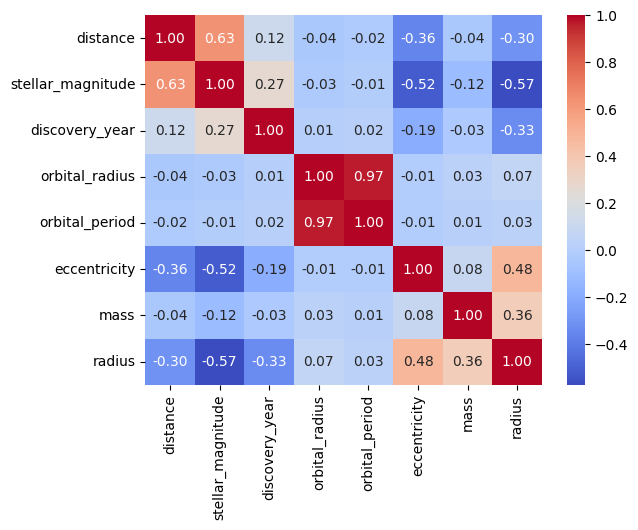

In [18]:
import seaborn as sns
sns.heatmap(cor_pairs, annot=True, fmt=".2f", cmap="coolwarm")

<Axes: >

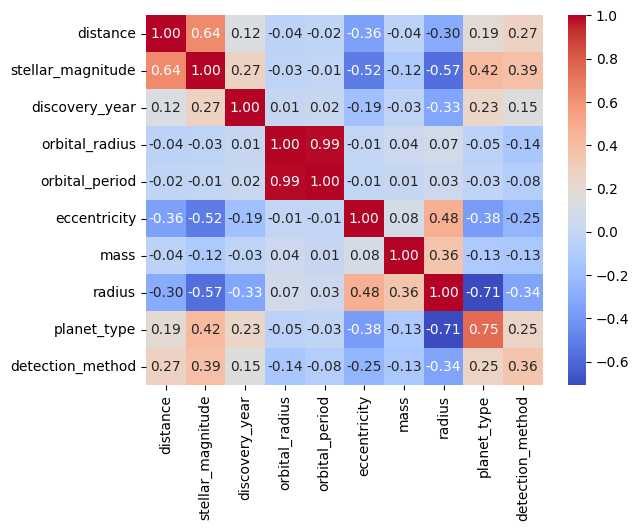

In [19]:
sns.heatmap(cov_pairs, annot=True, fmt=".2f", cmap="coolwarm")

<Axes: >

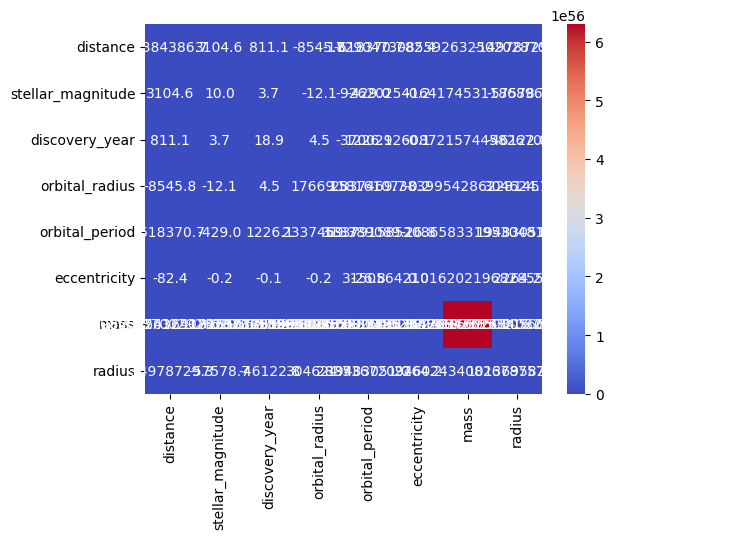

In [15]:
non_standard_cov_pairs = df_without_type.cov()
sns.heatmap(non_standard_cov_pairs, annot=True, fmt=".1f", cmap="coolwarm")

In [16]:
non_standard_cov_pairs

,distance,stellar_magnitude,discovery_year,orbital_radius,orbital_period,eccentricity,mass,radius
distance,2.384387e+06,3.104555e+03,8.111361e+02,-8.545762e+03,-6.183707e+05,-8.241405e+01,-1.729047e+30,-1.497873e+07
stellar_magnitude,3.104555e+03,1.002238e+01,3.680128e+00,-1.207004e+01,-4.289857e+02,-2.424612e-01,-9.262025e+27,-5.757870e+04
discovery_year,8.111361e+02,3.680128e+00,1.887974e+01,4.520163e+00,1.226088e+03,-1.205995e-01,-3.700293e+27,-4.612284e+04
orbital_radius,-8.545762e+03,-1.207004e+01,4.520163e+00,1.766951e+04,2.337470e+06,-1.733479e-01,1.181611e+29,3.046247e+05
orbital_period,-6.183707e+05,-4.289857e+02,1.226088e+03,2.337470e+06,3.133891e+08,-2.681365e+01,5.337916e+30,1.948305e+07
eccentricity,-8.241405e+01,-2.424612e-01,-1.205995e-01,-1.733479e-01,-2.681365e+01,2.202093e-02,3.150564e+26,2.264154e+03
mass,-1.729047e+30,-9.262025e+27,-3.700293e+27,1.181611e+29,5.337916e+30,3.150564e+26,6.295578e+56,2.835367e+32
radius,-1.497873e+07,-5.757870e+04,-4.612284e+04,3.046247e+05,1.948305e+07,2.264154e+03,2.835367e+32,1.013696e+09
